## 1)

Точное значение интеграла мы вычислили в прошлом дз:

$$\int\limits_{-1}^{5}\frac{1}{1 + 9x^2}dx = \bigg(\frac{1}{3}\cdot\arctan{(3x)}\bigg)\bigg{|}_{-1}^{5}$$

Для начала опишем все вспомогательные функции:

In [1]:
import numpy as np

def f(x):
    return 1.0 / (1 + 9 * x ** 2)

def get_antiderivative_value(point):
    return np.arctan(3 * point) / 3

def get_integral_value(lower, upper):
    return get_antiderivative_value(upper) - get_antiderivative_value(lower)

In [2]:
get_integral_value(-1, 5)

0.9177579784724423

Дальше мы будем исследовать все на итервале $[-1; 1]$ (потому что Многочлены Лежандра). Для этого сделаем замену переменных, чтобы исследуемый отрезок был $[-1; 1]$.

$$\int\limits_{-1}^{5}  \frac{1}{1 + 9x^2} dx = \int\limits_{-3}^{3} \frac{1}{1 + 9(x + 2)^2} dx = \int\limits_{-1}^{1} \frac{3}{1 + 9(3x+2)^2}dx$$

Напишем функцию для нахождения значения новой функции в точке.

In [95]:
def get_function_value(x):
    return 3.0 / (1 + 9 * (3 * x + 2) ** 2)

Опишем функцию для метода секущих (просто реализуем то, что нужно, ничего интересного)

In [15]:
def secant_method(start, func, eps):
    x_0, x_1 = start
    while True:
        x_new = x_1 - func(x_1) * (x_1 - x_0) / (func(x_1) - func(x_0))
        x_0, x_1 = x_1, x_new
        if np.abs(func(x_1)) < eps:
            break
    return x_1

Мы будем использовать перемежаемость корней, то есть будем считать их последовательно для многочленов последовательных степеней и брать начальные значения на отрезках на которые корни многочлена степени на один меньшей делят отрезок $[-1; 1]$.

In [5]:
from scipy.special import legendre

In [11]:
def calulate_roots(max_degree, eps):
    borders = [-1, 1]
    roots = []
    
    for deg in range(1, max_degree + 1):
        new_borders = [-1]
        roots.append([])
        for ind in range(deg):
            lt = borders[ind]
            rt = borders[ind + 1]
            root = secant_method(((2 * lt + rt) / 3, (lt + 2 * rt) / 3), legendre(deg), eps)
            roots[-1].append(root)
            new_borders.append(root)
        new_borders.append(1)
        borders = new_borders
    
    return roots

Позаимствуем из предыдущей домашки функцию для построения графиков

In [147]:
import matplotlib.pyplot as plt

def build_plot(xs, ys, xlabel='', ylabel='', title='', filename='plot', 
               plot_labels=None, color_shapes=None, points=None):
    xs = np.array(xs)
    ys = np.array(ys)
    if xs.ndim == 1:
        xs = np.array([xs])
        ys = np.array([ys])
    if color_shapes is None:
        color_shapes = ['' for _ in range(xs.shape[0] if xs.ndim > 1 else 1)]
    
    plt.clf()
    if points is not None:
        plt.plot(points[0], points[1], 'ro')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    for ind, (x, y) in enumerate(zip(xs, ys)):
        if plot_labels is not None:
            plt.plot(x, y, color_shapes[ind], label=plot_labels[ind])
        else:
            plt.plot(x, y, color_shapes[ind])
    if plot_labels is not None:
        plt.legend()
    plt.show()

Визуализируем значения в найденных корнях многочлена восьмой степени:

[-0.9602898564975638, -0.796666477394109, -0.5255324099163422, -0.1834346424957485, 0.18343464249615782, 0.5255324099213233, 0.7966664772540665, 0.9602898564986869]


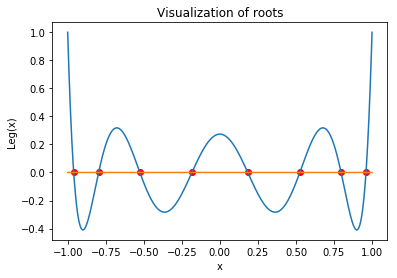

In [89]:
roots = calulate_roots(8, 1e-9)[-1]
leg = legendre(8)
xs = list(np.arange(-1, 1, 1e-5))
print(roots)
build_plot([xs, xs], [[leg(x) for x in xs], [0 for _ in xs]],
          'x', 'Leg(x)', 'Visualization of roots', points=(roots, [leg(root) for root in roots]))

Как видно, корни находятся. Теперь вернемся к базовой задаче.

Во-первых, скопируем из предыдущего дз составную формулу Симпсона.

In [101]:
def get_simpson_value(lower, upper, number_of_intervals, func):
    H = np.longdouble(upper - lower) / number_of_intervals
    total_sum = np.longdouble(0)
    for ind in range(2 * number_of_intervals + 1):
        current_point = lower + ind * H / 2
        coef = 1 if ind == 0 else 1 if ind == 2 * number_of_intervals else 2 if ind % 2 == 0 else 4
        total_sum += coef * func(current_point)
    return total_sum * H / 6

Убедимся, что мы значение интеграла правильное (с точностью до погрешности):

In [124]:
get_simpson_value(-1, 1, 10**6, get_function_value)

0.9177579784724424117

Ага, значение то.

Для начала, нам нужно посчитать веса (для этого просто реализуем то, что нужно, ничего хитрого):

In [104]:
def get_value(point, i, xs):
    xi = xs[i]
    result = 1.0
    for k, xk in enumerate(xs):
        if k != i:
            result *= (point - xk) / (xi - xk)
    return result

In [129]:
def get_weights(n, lower=-1, upper=1, intervals_number=10000, eps=1e-9):
    roots = calulate_roots(n, eps)[-1]
    return [get_simpson_value(lower, upper, intervals_number, lambda x: get_value(x, i, roots)) 
            for i in range(n)]

Далее, сравним посчитаые веса с весами из `numpy`

In [119]:
get_weights(10)

[0.06667134430389499443,
 0.14945134916733538199,
 0.21908636248347762229,
 0.26926671936354709002,
 0.29552422463087321878,
 0.2955242248492767952,
 0.26926671907564262123,
 0.21908636255700615615,
 0.14945134928990753627,
 0.066671344279038366794]

In [121]:
print(np.polynomial.legendre.leggauss(10)[1])

[0.06667134 0.14945135 0.21908636 0.26926672 0.29552422 0.29552422
 0.26926672 0.21908636 0.14945135 0.06667134]


Видим, что мы посчитали правильные (по крайней мере, сходящиеся с `numpy`) значения весов.

Теперь опишем функцию для подсчета интеграла с помошью формулы Гаусса.

In [138]:
def get_g_value(lower=-1, upper=1, n=50, func=get_function_value, eps=1e-9):
    roots = calulate_roots(n, eps)[-1]
    weights = get_weights(n, lower, upper)
    return sum([w * func(x) for x, w in zip(roots, weights)])

In [145]:
get_g_value(n=50)

0.9177586203988930678

Теперь построим интересующие нас графики погрешности (возможно, в разных масштабах).

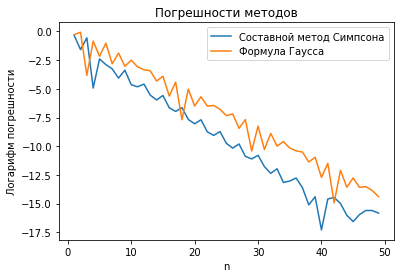

In [148]:
integral_value = get_integral_value(-1, 5)
xs = [range(1, 50, 1), range(1, 50, 1)]
ys = [[np.log(np.abs(integral_value - get_simpson_value(-1, 1, n, get_function_value))) for n in xs[0]], 
      [np.log(np.abs(integral_value - get_g_value(-1, 1, n, get_function_value))) for n in xs[1]]]

build_plot(xs, ys, 'n', 'Логарифм погрешности', 'Погрешности методов',
          plot_labels = ['Составной метод Симпсона', 'Формула Гаусса'])

Мы наблюдаем достаточно интересные результаты.
* Логарифм погрешности в формуле Гаусса видеть себя как линейная функция (есть сгладить). То есть погрешность эксопненционально убывает.
* В данном случае Гаусс дает худший результат, чем Симпсон.
* Абсолютное значение погрешности достаточно мало уже при n=50. Я бы сгенерировал больше значений, но это не очень быстро, а тенденция та же.